In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["sma","sma_corr"])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label == "mixed" and portfolio.allocation_type.label == "equal":
            filtered_portfolios.append(portfolio)
print(len(filtered_portfolios))

12


In [8]:
# additional_portfolios = []
# for portfolio in portfolios:
#     if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label != "long_short":
#         for member in Indicator:
#             pm = copy.deepcopy(portfolio)
#             pm.ranking_metric = member.label
#             additional_portfolios.append(pm)

In [9]:
rolling_window = 20
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            # price = Indicator.OPTIMAL.calculate(price,timeframe=rolling_window)
            price = Indicator.SMA.calculate(price,timeframe=rolling_window)
            price = Indicator.SMACorr.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [01:38<00:00, 114.50it/s]


In [10]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [11]:
analysises = []
for max_price in tqdm([1,2]):
    filtered_simulation = simulation[simulation["adjclose"]<=max_price].copy()
    for portfolio in filtered_portfolios:
        try:
            trades = portfolio.trades(filtered_simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = KPI.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            results["rolling_window"] = rolling_window
            results["max_price"] = max_price
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


In [12]:
a = pd.DataFrame(analysises)

In [13]:
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [14]:
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values("pnl",ascending=False)
top = a.head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,max_price
12,sma,long,STANDARD_DEV,mixed,535.804818,10616.884741,0.870043,3.352283,159.832815,1.081742,0.922113,0.491700,1.000602,3.333726,<financial_common.portfolio_management.portfol...,20,2
18,sma_corr,long,STANDARD_DEV,mixed,366.944568,6825.910381,0.880871,2.906992,126.228261,1.083331,0.921985,0.491304,1.001255,2.883495,<financial_common.portfolio_management.portfol...,20,2
20,sma_corr,long,ROLLING_DOLLAR_VOLUME,mixed,359.399854,1760.077578,0.850000,1.654177,217.268098,1.077416,0.919258,0.487154,0.996305,1.640526,<financial_common.portfolio_management.portfol...,20,2
0,sma,long,STANDARD_DEV,mixed,291.395443,723.025387,0.884851,2.974447,97.966255,1.067382,0.931474,0.495428,0.998806,2.944172,<financial_common.portfolio_management.portfol...,20,1
14,sma,long,ROLLING_DOLLAR_VOLUME,mixed,197.072671,986.922383,0.728942,1.691744,116.490829,1.074470,0.919507,0.482806,0.994324,1.666283,<financial_common.portfolio_management.portfol...,20,2
17,sma,long,DISTANCE,mixed,182.430486,5481.054122,0.886277,1.956409,93.247638,1.074502,0.925024,0.482806,0.997193,1.923946,<financial_common.portfolio_management.portfol...,20,2
6,sma_corr,long,STANDARD_DEV,mixed,181.949513,325.049533,0.717514,2.201773,82.637722,1.069041,0.930732,0.491064,0.998650,2.165882,<financial_common.portfolio_management.portfol...,20,1
22,sma_corr,long,DRAWDOWN,mixed,180.718105,1002.279092,0.788732,2.638786,68.485333,1.063532,0.929007,0.493676,0.995419,2.595477,<financial_common.portfolio_management.portfol...,20,2
23,sma_corr,long,DISTANCE,mixed,158.970480,3349.220633,0.886277,2.177567,73.003717,1.077977,0.924595,0.482016,0.998528,2.136103,<financial_common.portfolio_management.portfol...,20,2
11,sma_corr,long,DISTANCE,mixed,143.737044,249.911355,0.869244,4.117005,34.913013,1.065798,0.931133,0.489194,0.997010,4.032052,<financial_common.portfolio_management.portfol...,20,1


In [15]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()


In [16]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

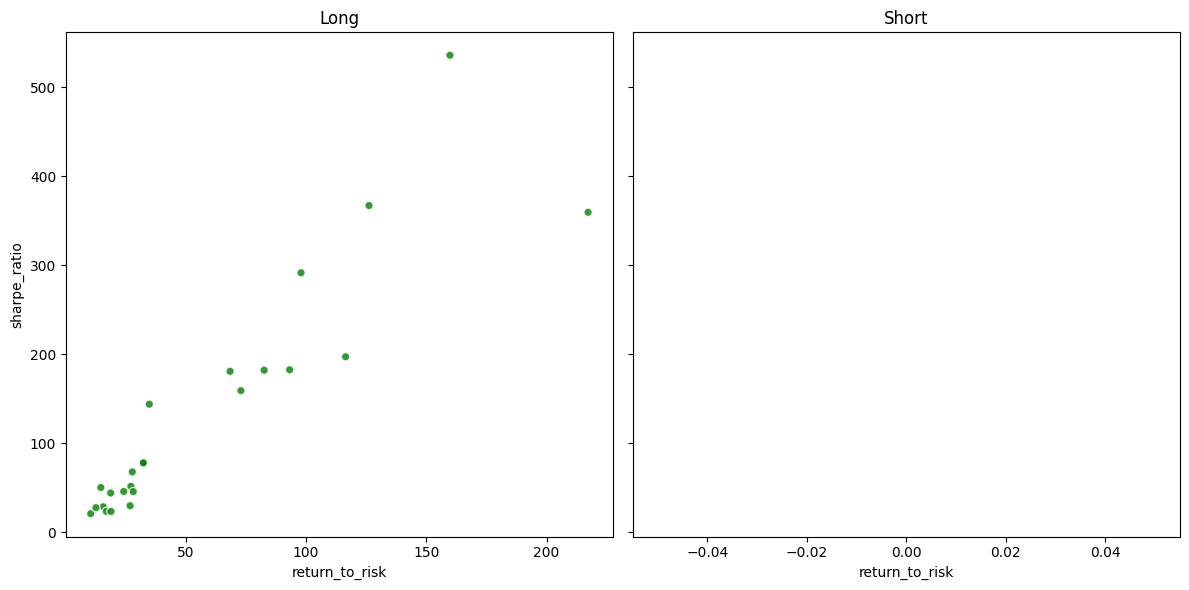

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [18]:
pm = top["portfolio"]
filtered_simulation = simulation[simulation["adjclose"]<=top["max_price"]]
trades = pm.trades(filtered_simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

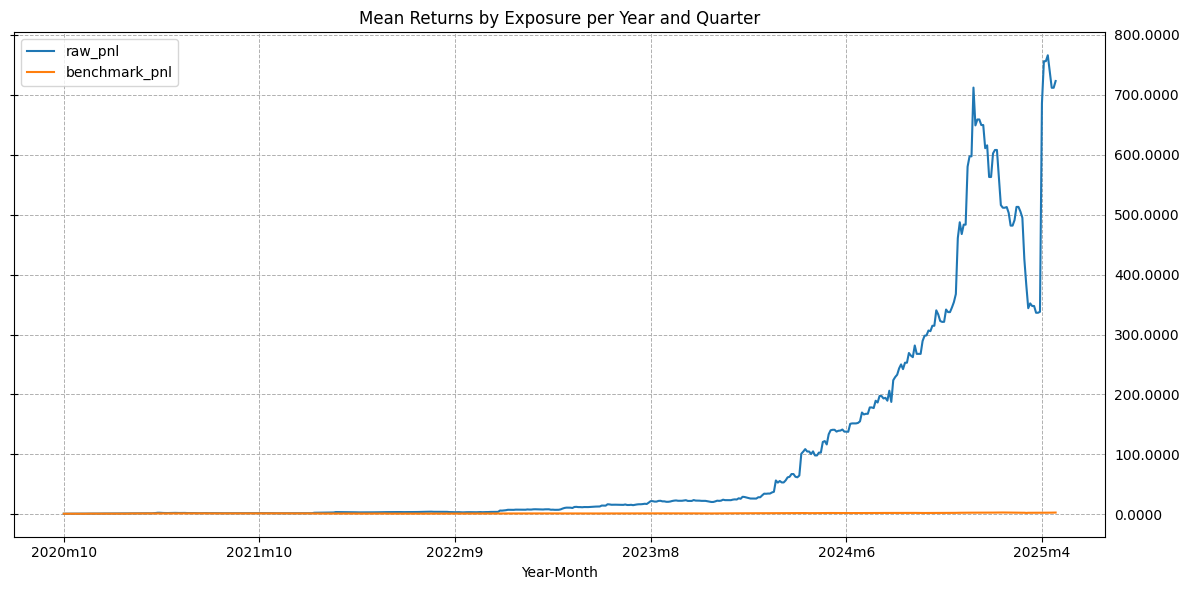

In [19]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [20]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
SISI,1.296660
TNFA,1.282799
BTU,1.185931
ENTO,1.185196
CODX,1.171303
...,...
EDUC,0.822335
TRUG,0.816305
EVTV,0.813475


In [21]:
len(filtered_simulation["ticker"].unique())

614

In [22]:
trades.sort_values("return",ascending=False).dropna().head(20)

,year,week,ticker,date,adjclose,sell_price,standard_dev,sma,risk,group_percentile,rank_percentile,position_type,weight,unweighted_return,winsorized_return,weighted_return,return,month,quarter
major_key,,,,,,,,,,,,,,,,,,,
2024_33_1.0,2024,33,UAMY,2024-08-16 00:00:00+00:00,0.3695,0.5299,0.020278,-0.057024,0.174979,1.0,1.000,1.0,1,1.434100,1.393333,1.434100,1.393333,8,3
2023_30_0.2,2023,30,FEMY,2023-07-28 00:00:00+00:00,0.3792,0.6500,0.075655,0.218028,0.302441,0.2,0.167,1.0,1,1.714135,1.393333,1.714135,1.393333,7,3
2023_42_0.6,2023,42,CTM,2023-10-20 00:00:00+00:00,0.2399,0.3500,0.042488,0.203424,0.350660,0.6,0.091,1.0,1,1.458941,1.393333,1.458941,1.393333,10,4
2024_38_0.0,2024,38,OMEX,2024-09-20 00:00:00+00:00,0.4963,0.8252,0.355507,-0.113675,0.154740,0.0,1.000,1.0,1,1.662704,1.393333,1.662704,1.393333,9,3
2022_42_0.2,2022,42,APCX,2022-10-21 00:00:00+00:00,0.4835,0.8849,0.093855,0.375624,0.185020,0.2,0.167,1.0,1,1.830196,1.393333,1.830196,1.393333,10,4
2022_49_0.7,2022,49,CLRO,2022-12-09 00:00:00+00:00,0.2878,0.5010,0.028844,-0.177688,0.101934,0.7,1.000,1.0,1,1.740792,1.393333,1.740792,1.393333,12,4
2024_13_0.2,2024,13,NXL,2024-03-27 00:00:00+00:00,0.5000,0.7800,0.081261,-0.139236,0.164269,0.2,1.000,1.0,1,1.560000,1.393333,1.560000,1.393333,3,1
2023_44_1.0,2023,44,QVCGA,2023-11-03 00:00:00+00:00,0.0811,0.1223,0.007569,0.185310,0.274543,1.0,0.143,1.0,1,1.508015,1.393333,1.508015,1.393333,11,4
2023_44_0.1,2023,44,VIVK,2023-11-03 00:00:00+00:00,0.5479,0.8004,0.158413,0.679854,0.155722,0.1,0.083,1.0,1,1.460851,1.393333,1.460851,1.393333,11,4


In [23]:
portfolio.sort_values("weighted_return",ascending=False)

,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,year,month,quarter,week,Year-Month
500,2025-04-24 00:00:00+00:00,2.028810,1.393333,277.376608,685.698047,244.64,2.711894,2025,4,2,17,2025m4
377,2024-03-27 00:00:00+00:00,1.560000,1.393333,72.400901,101.043572,193.78,2.148099,2024,3,1,13,2024m3
223,2022-12-21 00:00:00+00:00,1.531086,1.393333,5.569534,6.320126,123.89,1.373351,2022,12,4,51,2022m12
364,2024-02-13 00:00:00+00:00,1.501276,1.393333,45.421151,56.497762,169.25,1.876178,2024,2,1,7,2024m2
128,2022-03-01 00:00:00+00:00,1.361094,1.361094,2.626499,2.606437,124.71,1.382441,2022,3,1,9,2022m3
...,...,...,...,...,...,...,...,...,...,...,...,...
63,2021-04-16 00:00:00+00:00,0.901223,0.907597,2.113698,2.097553,137.64,1.525773,2021,4,2,15,2021m4
493,2025-04-09 00:00:00+00:00,0.898577,0.898577,202.448017,343.950684,234.34,2.597716,2025,4,2,15,2025m4
492,2025-04-04 00:00:00+00:00,0.898243,0.898243,225.298450,382.772611,210.28,2.331005,2025,4,2,14,2025m4
50,2021-02-19 00:00:00+00:00,0.895795,0.895795,2.329851,2.328407,132.13,1.464693,2021,2,1,7,2021m2
